In [4]:
import pandas as pd
import numpy as np
import calendar
import math

### Import Datasets

In [5]:
#Import Covid Dataset

ds_covid = pd.read_csv("Data/COVID/owid-covid-data.csv")
#If missing values: Interpolate: ds_covid = ds_covid.interpolate(method='nearest')
ds_covid = ds_covid.fillna(0)
ds_covid.date = pd.to_datetime(ds_covid.date)
ds_covid['month'] = pd.DatetimeIndex(ds_covid['date']).month
ds_covid['month'] = ds_covid['month'].apply(lambda x: calendar.month_name[x])
ds_covid['year'] = pd.DatetimeIndex(ds_covid['date']).year
ds_covid.set_index(['date'],inplace=True)

usa = ds_covid[ds_covid['iso_code']=='USA'][['new_cases','month', 'year']].reset_index().drop(columns=['date'])
usa_cases = usa['new_cases'].tolist()

#Log-normalize data
trans = np.ma.log(usa_cases)
usa_cases = trans.filled(0)

In [5]:
import matplotlib.pyplot as plt
from scipy import stats
import segmentation
from segmentation import draw_plot, draw_segments
from segmentation import sliding_window, bottomupsegment, swab
from segmentation import sumsquared_error, regression, compute_error

In [13]:
ds_dates = pd.read_csv("Data/COVID/owid-covid-data.csv")
usa_dates = ds_dates[ds_dates['iso_code']=='USA']
x_axis = usa_dates.date.tolist()

In [6]:
swab_data = swab(usa_cases, buffer_percent=0.1, bottom_up_error=3, best_line_error=3)
re_seg_data = segmentation.re_segment(swab_data, usa_cases)

/home/mandarsharma/Segmentation/segmentation.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p,residuals,rank,s) = np.linalg.lstsq(A,y)


In [24]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim, show, xticks
from matplotlib.lines import Line2D

font1 = {'family': 'DejaVu Sans',
        'color':  'Black',
        'weight': 'normal',
        'size': 14,
        }

font2 = {'family': 'DejaVu Sans',
        'color':  'Black',
        'weight': 'normal',
        'size': 8,
        }

def draw_plot(data, date, plot_title,color):
    plot(date,data,alpha=0.8,color=color)
    xticks(np.arange(0, len(date) + 1, 50))
    title(plot_title, fontdict = font1)
    xlabel("Time", fontdict = font1)
    ylabel("Number of daily COVID19 Cases", fontdict = font1)
    xlim((0,len(data)-1))

def draw_segments(segments, color):
    ax = gca()
    for idx, segment in enumerate(segments):
        line = Line2D([segment[0],segment[2]],[segment[1],segment[3]], color=color)
        ax.add_line(line)
        
def draw_segments_slope(segments, slopes, color):
    ax = gca()
    for idx, segment in enumerate(segments):
        line = Line2D([segment[0],segment[2]],[segment[1],segment[3]], color=color)
        x_center = (segment[0] + segment[2])/2
        y_center = 12.5
        slope_val = slopes[idx]
        if slope_val > 0 and slope_val <= 0.1:
            text = "Increase"
        elif slope_val > 0.1 and slope_val <= 0.6:
            text = "Sharp \nIncrease"
            y_center -= 0.25
        elif slope_val > 0.6:
            text = "Exponential \nIncrease"
            y_center -= 0.25
        elif slope_val == 0:
            text = "Flatline"
        elif slope_val < 0 and slope_val >= -0.1:
            text="Decrease"
        elif slope_val < -0.1 and slope_val >= -0.6:
            text = "Sharp \nDecrease"
            y_center -= 0.25
        elif slope_val < -0.6:
            text = "Exponential \nDecrease"
            y_center -= 0.25
        plt.text(x_center, y_center, text, fontdict=font2, ha="center")
        plt.axvline(x=segment[2])
        ax.add_line(line)

In [8]:
def cal_slope_vals(segmentation_data):
    slope_vals = []
    for segment in segmentation_data:
        start, end = segment[0], segment[2]
        sequence = usa_cases[start:end]
        res = stats.linregress(range(len(sequence)), sequence)
        slope_vals.append(res.slope)
    return slope_vals

In [9]:
sign = lambda x: math.copysign(1, x)
def cal_slope(segment, org_data):
    start, end = segment[0], segment[2]
    sequence = org_data[start:end]
    res = stats.linregress(range(len(sequence)), sequence)
    slope = res.slope
    return slope
    

In [10]:
def rearrange_segmentation(segmented_data, org_data):
    rearranged = []
    slopes = []
    for seg in segmented_data:
        slopes.append(sign(cal_slope(seg, org_data)))
    hold_out = None
    action = False
    for idx in range(len(slopes)-1):
        if slopes[idx] == slopes[idx+1] and action == False:
            hold_out = segmented_data[idx][0]
            action = True
        elif slopes[idx] == slopes[idx+1] and action == True:
            pass
        elif slopes[idx] != slopes[idx+1]:
            if hold_out is not None:
                rearranged.append((hold_out,segmented_data[idx+1][0]))
                action = False
                hold_out = None
            else:
                rearranged.append((segmented_data[idx][0],segmented_data[idx][2]))
            
    if slopes[-2] == slopes[-1]:
        rearranged.append((segmented_data[-2][0],segmented_data[-1][2]))
    else:
        rearranged.append((segmented_data[-2][0],segmented_data[-2][2]))
        rearranged.append((segmented_data[-1][0],segmented_data[-1][2]))
    return rearranged
    

In [11]:
def re_segment(segmented_data, org_data):
    return_list = []
    rearranged = rearrange_segmentation(segmented_data, org_data)
    for entry in rearranged:
        params = regression(org_data, [entry[0], entry[1]])
        return_list.append(params)
    return return_list

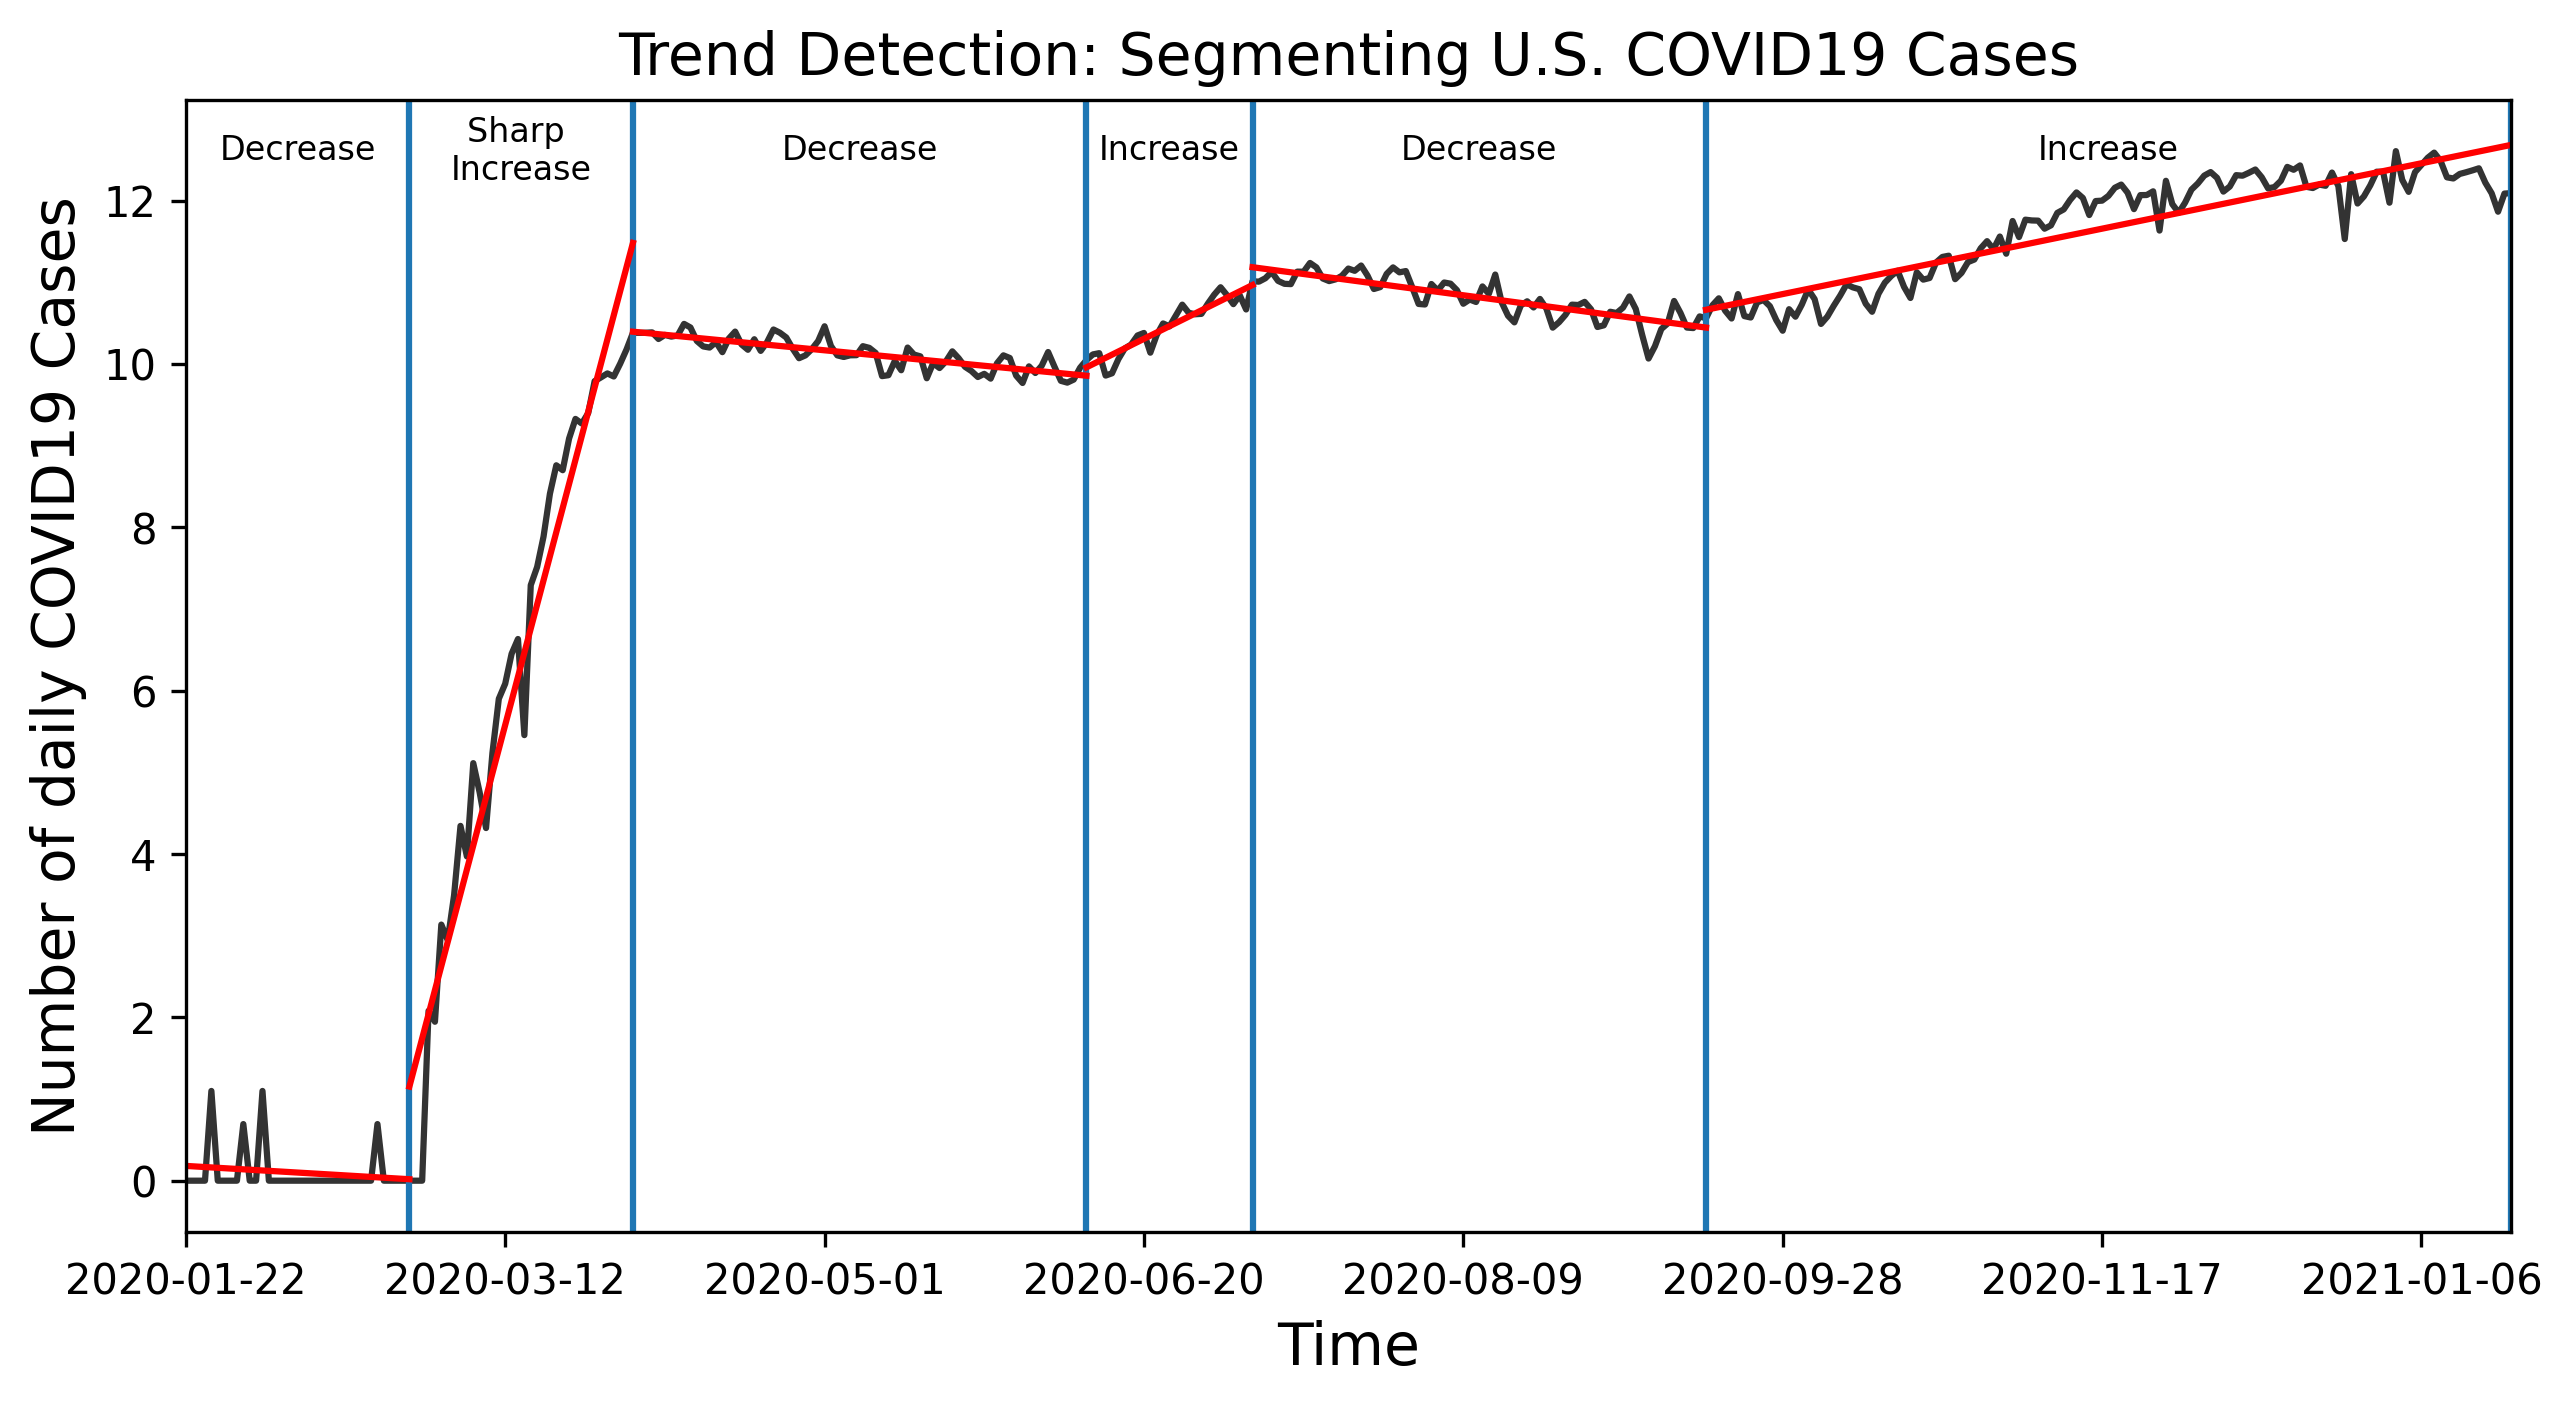

In [25]:
plt.figure(figsize=(10,5), dpi=300)
data = usa['new_cases'].tolist()
draw_plot(usa_cases, x_axis, 'Trend Detection: Segmenting U.S. COVID19 Cases', 'black')
slope_vals = cal_slope_vals(re_seg_data)
draw_segments_slope(re_seg_data, slope_vals,'r')

### Matrix Profile

In [ ]:
import matrixprofile as mp

In [ ]:
plt.plot(usa['new_cases'].tolist())

In [ ]:
data = usa['new_cases'].tolist()
#profile = mp.compute(data, windows=int(0.5 * len(data)))
profile = mp.compute(data, windows=4)
regimes = mp.discover.regimes(profile, num_regimes = 12)
print(regimes['regimes'])

In [ ]:
plt.plot(usa['new_cases'].tolist())
for entry in regimes['regimes']:
    plt.axvline(x=entry)